In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import os
import random


from utils.empirical_data import *
from mechanisms.mldp.mldp import *
from mechanisms.k_rr_mechanism import *
from mechanisms.mldp.repetitive_optimizer import *
from utils.synthetic_dataset import *
from mechanisms.exponential.exponential_mechanism import *
from utils.simpleinfotheory import *
from utils.normalize_error_matrix import *
from utils.alphabet import *
import matplotlib as mpl
import matplotlib.lines as mlines

mpl.rcParams.update({'font.size': 12})

In [ ]:
def mutual_info_pair(a, b):
    return mutualinformationempirical(xn=a, yn=b)[0]

In [ ]:
# I(A;A',B') = I(A;A') + I(A;B'|A')

def conditional_mutual_info(a, b, c):
    return conditionalmutualinformationempirical(a, b, c)

def total_info_leakage(A, A_prime, B_prime):
    return mutual_info_pair(A, A_prime) + conditional_mutual_info(A, B_prime, A_prime)

In [ ]:
def mutual_information(a, b):
    processed_a = []
    # print(a)
    # print(b)
    for i in a:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_a.append(np.array(actual))
    processed_a = np.array(processed_a)
    processed_b = []
    
    for i in b:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_b.append(np.array(actual))
    processed_b = np.array(processed_b)

    mi = []
    # print("processed_a", processed_a)
    # print("processed_b", processed_b)
    # for i in range(np.shape(processed_b)[1]):
    #     mi.append(mutual_info_pair(processed_a[:,i], processed_b[:,i]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_a[:,1]))
    # mi.append(mutual_info_pair(processed_b[:,1], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,1], processed_b[:,1]))
    mi.append(total_info_leakage(processed_a[:,0], processed_b[:,0], processed_b[:,1]))
    mi.append(total_info_leakage(processed_a[:,1], processed_b[:,1], processed_b[:,0]))
    # mi.append(total_info_leakage(processed_a[:,0], processed_b[:,1], processed_b[:,0]))
    return mi
    

In [ ]:
'''
    Test information leakage of attributes against their weight ratio.
'''

TARGET_UTILITY_ERROR = 0.15
NUM_ATTRIBUTES = 2
NUM_STATES = [6, 6]
DATASET_SIZE = 15000
EPS_ARRAY = np.arange(20, 70)*0.10
plt.tight_layout()

# priority_list = [{'1': 0.01*2/1.01, '0': 1*2/1.01}, {'1': 0.1*2/1.1, '0': 1*2/1.1}, {'1': 0.5*2/1.5, '0': 1*2/1.5}, {'1': 1, '0': 1}, {'1': 1*2/1.5, '0': 0.5*2/1.5}, {'1': 1*2/1.1, '0': 0.1*2/1.1}, {'1': 1*2/1.01, '0': 0.01*2/1.01}]
priority_list = [{'1': 0.01, '0': 1}, {'1': 0.1, '0': 1}, {'1': 0.5, '0': 1}, {'1': 1, '0': 1}, {'1': 1, '0': 0.5}, {'1': 1, '0': 0.1}, {'1': 1, '0': 0.01}]
# priority_list = [{'1': 100, '0': 1}, {'1': 50, '0': 1}, {'1': 20, '0': 1}, {'1': 1, '0': 1}] 
distribution_list = np.ones(36)/36 # [0.3, 0.01, 0.01, 0.01, 0.30, 0.01, 0.01, 0.01, 0.34]

colour_err_ = {"k-RR": "red", "Optimal k-RR": "blue"}
colour_mi_ = {"k-RR": ["lightsalmon", "brown"], "Optimal k-RR": ["green", "purple"]}

values_k_rr = []
values_optimal = []

for priority_dict in priority_list:
    random_dist = distribution_list
    TOTAL_STATES = 1
    alphabet_dict = {}
    for i in range(NUM_ATTRIBUTES):
        TOTAL_STATES *= NUM_STATES[i]
        alphabet_dict[str(i)] = np.arange(NUM_STATES[i])

    ALL_ALPHABET = create_alphabet(attributes_with_alphabet=alphabet_dict)
    STRING_ALL_ALPHABET = convert_alphabet_to_string(ALL_ALPHABET)
    ATTRIBUTE_LIST = list(alphabet_dict.keys())

    synthetic_dataset_constructor = Gen_Synthetic_Dataset(no_of_states = TOTAL_STATES, no_of_samples = DATASET_SIZE, alphabet=STRING_ALL_ALPHABET)
    correlated_synthetic_dataset = synthetic_dataset_constructor.gen_custom(distribution=random_dist)

    alphabet_dict = {}
    for i in range(len(ALL_ALPHABET)):
        alphabet_dict[str(ALL_ALPHABET[i])] = i
    normalize_error_matrix = Normalize_error_matrix(attribute_list=ATTRIBUTE_LIST, alphabet=ALL_ALPHABET, priority_dict=priority_dict, alphabet_dict=alphabet_dict)
    err_matrix = normalize_error_matrix.normalized_error_matrix
    # sns.heatmap(err_matrix)
    # plt.show()
    random_response_mechanism = Randomized_Response(STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix)

    optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = random_dist, STATE_COUNT = TOTAL_STATES, INPUT_ALPHABET = STRING_ALL_ALPHABET, normalized_objective_err_matrix = err_matrix, 
                        TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=True)

    mechanisms_dict = {"k-RR": random_response_mechanism, "Optimal k-RR": optimal_random_response_mechanism}

    error_dict = {}
    mi_dict = {}

    for key in list(mechanisms_dict.keys()):
        error_dict[key] = []
        mi_dict[key] = []

    for mechanism in list(mechanisms_dict.keys()):
        for eps in EPS_ARRAY:
        
            __tot_error = 0
            __perturbed_value_list = []
            for entry in correlated_synthetic_dataset:
                __perturbed_value_list.append(mechanisms_dict[mechanism].gen_random_output(actual_value=entry, eps=eps)[0])

                __error = normalize_error_matrix.get_value_error(actual=entry, perturbed=__perturbed_value_list[-1])
                __tot_error += __error
            
            error_dict[mechanism].append(__tot_error/len(correlated_synthetic_dataset))

            if error_dict[mechanism][-1] < TARGET_UTILITY_ERROR:
                mi_dict[mechanism].append(mutual_information(correlated_synthetic_dataset, __perturbed_value_list))
                break

    values_k_rr.append(mi_dict["k-RR"][0])
    values_optimal.append(mi_dict["Optimal k-RR"][0])

values_k_rr = np.array(values_k_rr)
values_optimal = np.array(values_optimal)

x = np.arange(len(priority_list))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_k_rr[:, 0], width, label='Feature 1')
rects2 = ax.bar(x + width/2, values_k_rr[:, 1], width, label='Feature 2')
rects2 = ax.bar(x + width + width/2, values_optimal[:, 0], width, label='Feature 2')
rects2 = ax.bar(x + width*2 + width/2, values_optimal[:, 1], width, label='Feature 2')
plt.show()



In [12]:
def get_mechanism_key(predessor_index_list):
    __key = ""
    for i in predessor_index_list:
        __key += str(i) + " "
    return __key

def string_to_list(s):
    l = []
    actual_split = s.split(" ")
    for j in actual_split:
        if j != "" :
            l.append((j))
    return l

def get_conditional_dist(attribute_num, predessor_index_list, individual_alphabet, global_alphabet, prior_dist):
    __marginal_prob_dist = []
    k = len(predessor_index_list)
    # print("predessor_index_list ", predessor_index_list)
    for i in individual_alphabet:
        __marginal_prob = 0
        for index_j, j in enumerate(global_alphabet):
            # print("j[:k] ", j[:k], list(j[:k]) == list(predessor_index_list), j[attribute_num] == i, k == 0)
            if j[attribute_num] == i and (k == 0 or list(j[:k]) == list(predessor_index_list)):
                __marginal_prob += prior_dist[index_j]
        __marginal_prob_dist.append(__marginal_prob)
    return __marginal_prob_dist/sum(__marginal_prob_dist)


def create_optimal_mechnism_dict(alphabet = [], alphabet_dict = {}, prior_dist = [], err_type = "0_1", uniform = False):
    mechanism_list = []
    # print("alphabet ", len(alphabet), alphabet)
    # print("alphabet_dict ", len(alphabet_dict), alphabet_dict)
    # print("prior_dist ", len(prior_dist), prior_dist)
    for i in range(NUM_ATTRIBUTES):
        mechanism_dict = {}
        individual_alphabet = alphabet_dict[str(i)]
        # print("individual_alphabet ", convert_alphabet_to_string(individual_alphabet))
        state_count = len(individual_alphabet)
        normalize_error_matrix = Normalize_error_matrix(attribute_list=[str(i)], alphabet=individual_alphabet, priority_dict=priority_dict, alphabet_dict=alphabet_dict, err_type=err_type)
        err_matrix = normalize_error_matrix.normalized_error_matrix
        # sns.heatmap(err_matrix)
        # plt.show()
        for index_j, j in enumerate(alphabet):
            predessor_index_list = j[:i]
            if len(predessor_index_list) == 0:
                if uniform:
                    conditional_prior_dist = np.ones(len(individual_alphabet))/len(individual_alphabet)
                else:
                    conditional_prior_dist = get_conditional_dist(i, predessor_index_list, (individual_alphabet), alphabet, prior_dist)
                # err_matrix_1 = err_matrix*(1- conditional_prior_dist) #(1/(conditional_prior_dist+0.00000001))
                # err_matrix_1 = err_matrix_1 / np.max(err_matrix_1)
                # sns.heatmap(err_matrix_1)
                # plt.show()
                # print("conditional_prior_dist ", len(conditional_prior_dist), conditional_prior_dist)
                # conditional_prior_dist = np.ones(len(conditional_prior_dist))/len(conditional_prior_dist)
                optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = conditional_prior_dist, STATE_COUNT = state_count, INPUT_ALPHABET = convert_alphabet_to_string(individual_alphabet), normalized_objective_err_matrix = err_matrix, 
                    TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=False)
                mechanism_dict["0"] = optimal_random_response_mechanism
                # sns.heatmap(optimal_random_response_mechanism.get_mechanism(2), annot=True)
                # plt.show()
                break
            __key = get_mechanism_key(predessor_index_list = predessor_index_list)
            # print(__key)
            if __key not in mechanism_dict.keys():
                if uniform:
                    conditional_prior_dist = np.ones(len(individual_alphabet))/len(individual_alphabet)
                else:
                    conditional_prior_dist = get_conditional_dist(i, predessor_index_list, (individual_alphabet), alphabet, prior_dist)
                # err_matrix_2 = err_matrix*(1- conditional_prior_dist) # *(1/(conditional_prior_dist+0.00000001))
                # err_matrix_2 = err_matrix_2 / np.max(err_matrix_2)
                # sns.heatmap(err_matrix_2)
                # plt.show()
                # print("conditional_prior_dist ", len(conditional_prior_dist), conditional_prior_dist)
                # conditional_prior_dist = np.ones(len(conditional_prior_dist))/len(conditional_prior_dist)
                optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = conditional_prior_dist, STATE_COUNT = state_count, INPUT_ALPHABET = convert_alphabet_to_string(individual_alphabet), normalized_objective_err_matrix = err_matrix, 
                    TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=False)
                mechanism_dict[__key] = optimal_random_response_mechanism
                # sns.heatmap(optimal_random_response_mechanism.get_mechanism(2), annot=True)
                # plt.show()
        mechanism_list.append(mechanism_dict)
        # print("mechanism_list ", mechanism_list)
    return mechanism_list

def get_randomized_value(actual_value, eps, mechanism_list):
    actual_value = string_to_list(actual_value)
    last_value = None
    randomized_value_list = ""
    # print("actual_value ", actual_value)
    for index_i, i in enumerate(actual_value):
        if last_value == None:
            last_value = mechanism_list[index_i]["0"].gen_random_output(actual_value=i, eps=eps)[0]
        else:
            __key = randomized_value_list  #get_mechanism_key(predessor_index_list=randomized_value_list)
            last_value = mechanism_list[index_i][__key].gen_random_output(actual_value=i, eps=eps)[0]
        randomized_value_list += last_value + " "
    return randomized_value_list

            
create_optimal_mechnism_dict(alphabet=ALL_ALPHABET, alphabet_dict=alphabet_dict, prior_dist=random_dist, err_type="0_1")

KeyError: '0'

1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
mechanism  [0.6731, 0.6712, 0.6622, 0.6625, 0.6616, 0.6668, 0.6719, 0.675, 0.6605, 0.6635]
mechanism  [0.3704, 0.3761, 0.3739, 0.3366, 0.3765, 0.3737, 0.3941, 0.3329, 0.3788, 0.3801]
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
mechanism  [0.6599, 0.6661, 0.6653, 0.6617, 0.6607, 0.6719, 0.6764, 0.6731, 0.6738, 0.6766]
mechanism  [0.3524, 0.3633, 0.366, 0.3665, 0.3762, 0.3902, 0.3757, 0.3428, 0.3774, 0.3508]
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.0
1.0
2
2
2
2
1.0
1.0
1.

<Figure size 640x480 with 0 Axes>

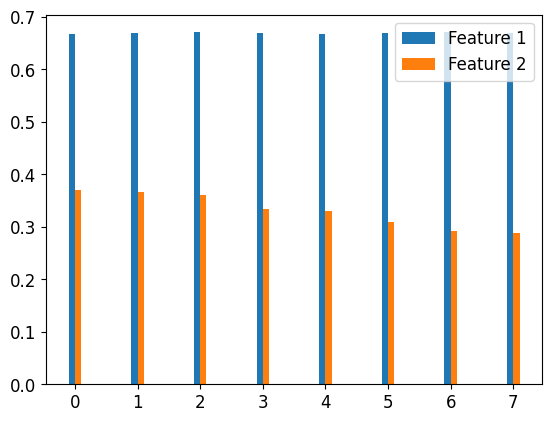

In [14]:
'''
    Test information leakage of attributes against different corrlations
'''

TARGET_UTILITY_ERROR = 0.2
NUM_ATTRIBUTES = 2
NUM_STATES = [3, 3]
DATASET_SIZE = 10000
EPS_ARRAY = np.arange(40)*0.16
plt.tight_layout()

priority_list = [{'1': 0.01, '0': 1}, {'1': 0.1, '0': 1}, {'1': 0.5, '0': 1}, {'1': 1, '0': 1}, {'1': 1, '0': 0.5}, {'1': 1, '0': 0.1}, {'1': 1, '0': 0.01}]
# priority_list = [{'1': 100, '0': 1}, {'1': 50, '0': 1}, {'1': 20, '0': 1}, {'1': 1, '0': 1}] 
# distribution_list = [0.3, 0.01, 0.01, 0.01, 0.30, 0.01, 0.01, 0.01, 0.34]

synthetic_dist = Gen_Synthetic_Distribution(original_dist=np.ones(9)/9, no_samples=20, sample_count_per_sample=100, div_type = "MI", attribute_state_count=NUM_STATES)
synthetic_dist.create_distribution()
synthetic_distribution_dict = synthetic_dist.get_synthetic_distribution()
distribution_list = list(synthetic_distribution_dict.values())

colour_err_ = {"k-RR": "red", "Optimal k-RR": "blue"}
colour_mi_ = {"k-RR": ["lightsalmon", "brown"], "Optimal k-RR": ["green", "purple"]}

values_k_rr = []
values_optimal = []

for random_dist_list in distribution_list:
    if len(random_dist_list) == 0:
        continue
    error_dict = {}
    mi_dict = {}

    for key in list(mechanisms_dict.keys()):
        error_dict[key] = []
        mi_dict[key] = []
    for random_dist in random_dist_list[:min(10,len(random_dist_list))]:
        priority_dict =  {'1': 1, '0': 1}
        TOTAL_STATES = 1
        alphabet_dict = {}
        for i in range(NUM_ATTRIBUTES):
            TOTAL_STATES *= NUM_STATES[i]
            alphabet_dict[str(i)] = np.arange(NUM_STATES[i])

        ALL_ALPHABET = create_alphabet(attributes_with_alphabet=alphabet_dict)
        STRING_ALL_ALPHABET = convert_alphabet_to_string(ALL_ALPHABET)
        ATTRIBUTE_LIST = list(alphabet_dict.keys())
        alphabet_dict_ = alphabet_dict

        synthetic_dataset_constructor = Gen_Synthetic_Dataset(no_of_states = TOTAL_STATES, no_of_samples = DATASET_SIZE, alphabet=STRING_ALL_ALPHABET)
        correlated_synthetic_dataset = synthetic_dataset_constructor.gen_custom(distribution=random_dist)

        alphabet_dict = {}
        for i in range(len(ALL_ALPHABET)):
            alphabet_dict[str(ALL_ALPHABET[i])] = i
        normalize_error_matrix = Normalize_error_matrix(attribute_list=ATTRIBUTE_LIST, alphabet=ALL_ALPHABET, priority_dict=priority_dict, alphabet_dict=alphabet_dict)
        err_matrix = normalize_error_matrix.normalized_error_matrix
        # sns.heatmap(err_matrix)
        # plt.show()
        random_response_mechanism = Randomized_Response(STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix)
        # random_response_mechanism = Exponential_mechanism(prior_dist=random_dist, STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix, only_err_matrix=True)
        # optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = random_dist, STATE_COUNT = TOTAL_STATES, INPUT_ALPHABET = STRING_ALL_ALPHABET, normalized_objective_err_matrix = err_matrix, 
        #                     TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=True)
        optimal_mechanism_list = create_optimal_mechnism_dict(alphabet=ALL_ALPHABET, alphabet_dict=alphabet_dict_, prior_dist=random_dist, err_type="0_1")
        optimal_mechanism_list_divided = create_optimal_mechnism_dict(alphabet=ALL_ALPHABET, alphabet_dict=alphabet_dict_, prior_dist=random_dist, err_type="0_1", uniform=True)
        mechanisms_dict = {"k-RR": random_response_mechanism, "Optimal k-RR": optimal_random_response_mechanism}

        

        for mechanism in list(mechanisms_dict.keys()):
            for eps in [2]: # EPS_ARRAY:
            
                __tot_error = 0
                __perturbed_value_list = []
                for entry in correlated_synthetic_dataset:
                    if mechanism == "Optimal k-RR":
                        __perturbed_value_list.append(get_randomized_value(actual_value=entry, eps=eps, mechanism_list=optimal_mechanism_list))
                    elif mechanism == "k-RR":
                        __perturbed_value_list.append(get_randomized_value(actual_value=entry, eps=eps/2, mechanism_list=optimal_mechanism_list_divided))
                    else:
                        __perturbed_value_list.append(mechanisms_dict[mechanism].gen_random_output(actual_value=entry, eps=eps)[0])

                    __error = normalize_error_matrix.get_value_error(actual=entry, perturbed=__perturbed_value_list[-1])
                    __tot_error += __error
                
                error_dict[mechanism].append(__tot_error/len(correlated_synthetic_dataset))
    for mechanism in list(mechanisms_dict.keys()):
        print("mechanism ",error_dict[mechanism])
        error_dict[mechanism] = sum(error_dict[mechanism])/len(error_dict[mechanism])
    values_k_rr.append(error_dict["k-RR"])
    values_optimal.append(error_dict["Optimal k-RR"])

# values_k_rr = np.array(values_k_rr)
# values_optimal = np.array(values_optimal)

x = np.arange(len(values_k_rr))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_k_rr, width, label='Feature 1')
rects2 = ax.bar(x + width/2, values_optimal, width, label='Feature 2')
plt.legend()
plt.show()



In [ ]:
x = np.arange(len(values_k_rr))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_k_rr, width, label='Feature 1')
rects2 = ax.bar(x + width/2, values_optimal, width, label='Feature 2')
plt.legend()
plt.show()